In [820]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution
from keras.models import Model, load_model
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy, kl_divergence
from keras.losses import MeanSquaredError as mse
from keras import optimizers

from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

from argparse import Namespace
from pathlib import Path
from collections import OrderedDict
import sklearn
from sklearn import preprocessing
import os

In [821]:
raw_dt = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv")
# raw_dt = pd.read_csv(datafile_path)
raw_dt.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


Text(0.5, 1.0, 'Original Dataset')

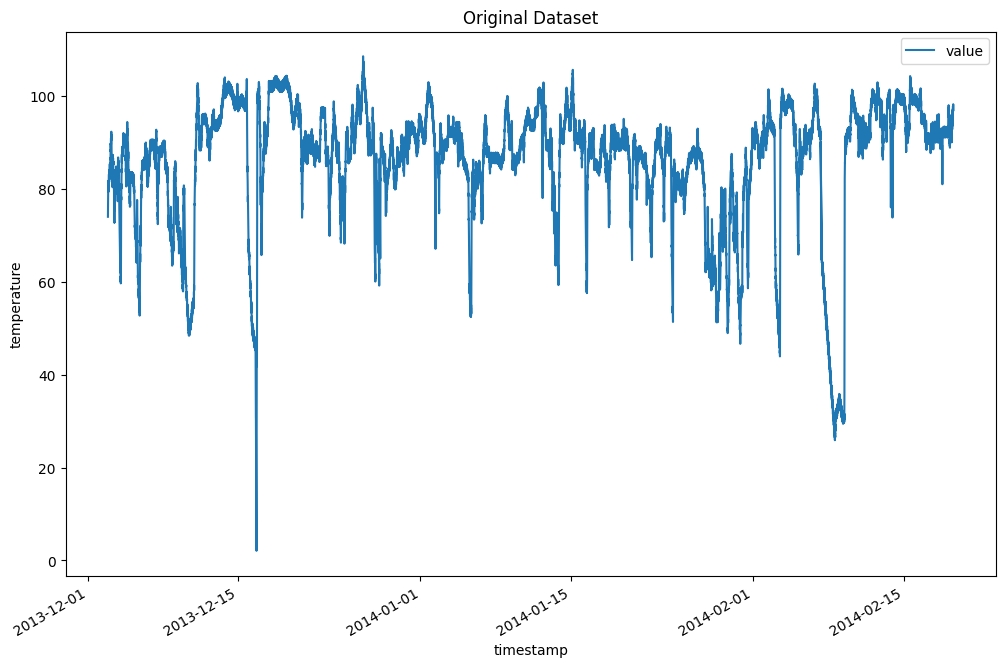

In [822]:
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='value', figsize=(12, 8))
plt.ylabel("temperature")
plt.title("Original Dataset")

In [823]:
data['label'] = 1
instances= [["2013-12-10 06:25:00","2013-12-12 05:35:00"],
            ["2013-12-15 17:50:00","2013-12-17 17:00:00"],
            ["2014-01-27 14:20:00","2014-01-29 13:30:00"],
            ["2014-02-07 14:55:00","2014-02-09 14:05:00"]]


In [824]:
for i in range(len(instances)): 
    start = pd.to_datetime(instances[i][0])
    end = pd.to_datetime(instances[i][1])
    data.loc[(data['timestamp'] >= start) & (data['timestamp'] <= end), 'label'] = 0

In [825]:
data_w_ts=data.copy()
data_w_ts

,timestamp,value,label
0,2013-12-02 21:15:00,73.967322,1
1,2013-12-02 21:20:00,74.935882,1
2,2013-12-02 21:25:00,76.124162,1
3,2013-12-02 21:30:00,78.140707,1
4,2013-12-02 21:35:00,79.329836,1
...,...,...,...
22690,2014-02-19 15:05:00,98.185415,1
22691,2014-02-19 15:10:00,97.804168,1
22692,2014-02-19 15:15:00,97.135468,1
22693,2014-02-19 15:20:00,98.056852,1


In [826]:
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['hour_min'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60

data['day_of_week'] = data['timestamp'].dt.dayofweek
data['holiday'] = 0
data.loc[(data['day'] == 25) & (data['month'] == 12),'holiday'] = 1  # Christmas
data.loc[(data['day'] == 1) & (data['month'] == 1),'holiday'] = 1  # New Year's Day
data.head()

,timestamp,value,label,day,month,hour_min,day_of_week,holiday
0,2013-12-02 21:15:00,73.967322,1,2,12,21.250000,0,0
1,2013-12-02 21:20:00,74.935882,1,2,12,21.333333,0,0
2,2013-12-02 21:25:00,76.124162,1,2,12,21.416667,0,0
3,2013-12-02 21:30:00,78.140707,1,2,12,21.500000,0,0
4,2013-12-02 21:35:00,79.329836,1,2,12,21.583333,0,0


In [827]:
holidays = data.loc[data['holiday'] == 1, 'timestamp'].dt.date.unique()
holidays

array([datetime.date(2013, 12, 25), datetime.date(2014, 1, 1)],
      dtype=object)

In [828]:
for i, hd in enumerate(holidays):
    data['hol_' + str(i)] = data['timestamp'].dt.date - hd

In [829]:
for i in range(data.shape[0]):
    if np.abs(data.loc[data.index[i], 'hol_0']) <= np.abs(data.loc[data.index[i], 'hol_1']):
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_0']
    else:
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_1']

In [830]:
data['gap_holiday'] = data['gap_holiday'].dt.days
data.drop(['hol_0', 'hol_1'], axis=1, inplace=True)
data['t'] = (data['timestamp'].astype(np.int64)/1e11).astype(np.int64)
data.drop('timestamp', axis=1, inplace=True)
data

,value,label,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,73.967322,1,2,12,21.250000,0,0,-23,13860189
1,74.935882,1,2,12,21.333333,0,0,-23,13860192
2,76.124162,1,2,12,21.416667,0,0,-23,13860195
3,78.140707,1,2,12,21.500000,0,0,-23,13860198
4,79.329836,1,2,12,21.583333,0,0,-23,13860201
...,...,...,...,...,...,...,...,...,...
22690,98.185415,1,19,2,15.083333,2,0,49,13928223
22691,97.804168,1,19,2,15.166667,2,0,49,13928226
22692,97.135468,1,19,2,15.250000,2,0,49,13928229
22693,98.056852,1,19,2,15.333333,2,0,49,13928232


In [831]:
cont_vars = ['value', 'hour_min', 'gap_holiday', 't']
cat_vars = ['day', 'month', 'day_of_week', 'holiday']

In [832]:
from sklearn.preprocessing import LabelEncoder

# label_encoders = [LabelEncoder() for _ in cat_vars] 
# for col, enc in zip(cat_vars, label_encoders):
#     data[col] = enc.fit_transform(data[col])
    
data= pd.get_dummies(data.iloc[:,:], columns= cat_vars )
data

,value,label,hour_min,gap_holiday,t,day_1,day_2,day_3,day_4,day_5,...,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
0,73.967322,1,21.250000,-23,13860189,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
1,74.935882,1,21.333333,-23,13860192,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
2,76.124162,1,21.416667,-23,13860195,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
3,78.140707,1,21.500000,-23,13860198,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
4,79.329836,1,21.583333,-23,13860201,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22690,98.185415,1,15.083333,49,13928223,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22691,97.804168,1,15.166667,49,13928226,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22692,97.135468,1,15.250000,49,13928229,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22693,98.056852,1,15.333333,49,13928232,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False


In [833]:
print(data.keys())

Index(['value', 'label', 'hour_min', 'gap_holiday', 't', 'day_1', 'day_2',
       'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24',
       'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31',
       'month_1', 'month_2', 'month_12', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'holiday_0', 'holiday_1'],
      dtype='object')


In [834]:
# Splitting to train and test
test_ratio = 0.3
start = 0       # or int(len(data) * 0.25 )  # or 0 
tr_data = data.iloc[start: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]

In [835]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])

In [836]:
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

In [837]:
tr_data_scaled

,value,label,hour_min,gap_holiday,t,day_1,day_2,day_3,day_4,day_5,...,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
0,-1.224398,1,1.336685,-1.866199,-1.732808,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
1,-1.134136,1,1.348691,-1.866199,-1.732590,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
2,-1.023399,1,1.360698,-1.866199,-1.732372,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
3,-0.835474,1,1.372704,-1.866199,-1.732153,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
4,-0.724658,1,1.384711,-1.866199,-1.731935,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15881,0.127174,1,1.684873,1.825637,1.731208,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15882,0.120220,1,1.696879,1.825637,1.731426,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15883,0.140016,1,1.708885,1.825637,1.731644,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15884,0.060621,1,1.720892,1.825637,1.731863,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False


In [838]:
tst_data_scaled

,value,label,hour_min,gap_holiday,t,day_1,day_2,day_3,day_4,day_5,...,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
15886,0.128276,1,-1.712961,1.902550,1.732299,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
15887,-0.038872,1,-1.700954,1.902550,1.732517,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
15888,0.088313,1,-1.688948,1.902550,1.732736,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
15889,0.124557,1,-1.676941,1.902550,1.732954,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
15890,0.014094,1,-1.664935,1.902550,1.733172,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22690,1.032520,1,0.448205,3.671554,3.217532,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22691,0.996991,1,0.460212,3.671554,3.217751,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22692,0.934674,1,0.472218,3.671554,3.217969,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22693,1.020539,1,0.484225,3.671554,3.218187,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False


In [839]:
train = tr_data_scaled[tr_data_scaled.label != 0]
train= train.drop(columns=['label'])
train

,value,hour_min,gap_holiday,t,day_1,day_2,day_3,day_4,day_5,day_6,...,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
0,-1.224398,1.336685,-1.866199,-1.732808,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,True,False
1,-1.134136,1.348691,-1.866199,-1.732590,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,True,False
2,-1.023399,1.360698,-1.866199,-1.732372,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,True,False
3,-0.835474,1.372704,-1.866199,-1.732153,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,True,False
4,-0.724658,1.384711,-1.866199,-1.731935,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15881,0.127174,1.684873,1.825637,1.731208,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15882,0.120220,1.696879,1.825637,1.731426,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15883,0.140016,1.708885,1.825637,1.731644,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
15884,0.060621,1.720892,1.825637,1.731863,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False


In [840]:
labels_of_test = tst_data_scaled['label'].tolist()
test= tst_data_scaled.drop(columns=['label'])

In [841]:
#Converting df to arrays
train= train.to_numpy()
train= np.asarray(train).astype(np.float32)
test= test.to_numpy()
test= np.asarray(test).astype(np.float32)

In [842]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [843]:
def sample(args):
    z_mean, z_log_var = args
    batch = tf.keras.backend.shape(z_mean)[0]
    dim = tf.keras.backend.int_shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

In [844]:
class VAELossLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs
        # compute the average MSE error, then scale it up, i.e. simply sum on all axes
        reconstruction_loss = tf.reduce_sum(tf.square(x - x_decoded_mean))
        # compute the KL loss
        kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        # return the average loss over all 
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)    
        self.add_loss(total_loss)
        return x  # Dummy output

In [845]:
original_dim = train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [846]:
print(input_shape)

(47,)


In [847]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_102 (Dense)   │ (None, 23)        │      1,104 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 15)        │        360 │ dense_102[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 15)        │        360 │ dense_102[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 15)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,824 (7.12 KB)

 Trainable params: 1,824 (7.12 KB)

 Non-trainable params: 0 (0.00 B)

In [848]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 23)             │           368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 47)             │         1,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,496 (5.84 KB)

 Trainable params: 1,496 (5.84 KB)

 Non-trainable params: 0 (0.00 B)

In [849]:
# full VAE model
inputs = Input(shape=input_shape, name='encoder_input')

x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# Use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')

# Decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs))
vae_loss_layer = VAELossLayer()([inputs, outputs, z_mean, z_log_var])

vae_model = Model(inputs, [outputs, vae_loss_layer], name='vae_mlp')

In [850]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=lambda y_true, y_pred: y_pred)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(train,train, 
                        shuffle=True,
                        epochs=1000,
                        batch_size=256,
                        validation_split=0.25,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])


Model: "vae_mlp"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 15)        │      1,824 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_105 (Dense)   │ (None, 23)        │      1,104 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 47)        │      1,496 │ encoder[0][0]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 15)        │        360 │ dense_105[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 15)        │        360 │ dense_105[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer_17   │ (None, 47)        │          0 │ encoder_input[0]… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,320 (12.97 KB)

 Trainable params: 3,320 (12.97 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4049.9248 - val_loss: 3468.8608
Epoch 2/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3926.6172 - val_loss: 3362.9832
Epoch 3/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3808.0012 - val_loss: 3258.0100
Epoch 4/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3689.9246 - val_loss: 3161.5989
Epoch 5/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3561.3660 - val_loss: 3058.9858
Epoch 6/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3431.7581 - val_loss: 2964.1931
Epoch 7/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3310.7236 - val_loss: 2859.2092
Epoch 8/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3174.2617 - val_loss: 2755.2151
Epoch 9/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3029.1721 - val_loss: 2652.2957
Epoch 10/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2868.0042 - val_loss: 2557.2935
Epoch 11/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2697.0356 - val_lo

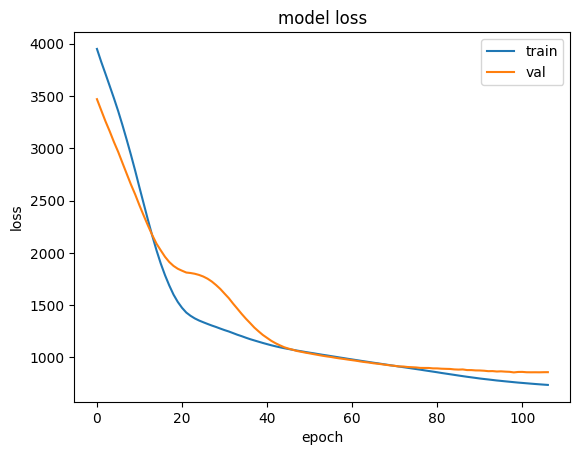

In [851]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [852]:
train_pred = vae_model.predict(train)[0]

461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step


In [853]:
mae_vector = get_error_term(train_pred, train, _rmse=True)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
# print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

# error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.23184268176555634
median error 0.2274620682001114
99Q: 0.4977709943056106


(array([ 20., 118., 217., 310., 408., 429., 409., 336., 378., 545., 426.,
        532., 570., 639., 680., 566., 662., 694., 612., 757., 669., 743.,
        492., 358., 286., 378., 417., 243., 190., 198., 221., 306., 195.,
        145., 152.,  96.,  57.,  58.,  38.,  25.,  15.,  22.,  21.,  23.,
         22.,  18.,  12.,  20.,  14.,  10.]),
 array([0.03774464, 0.04878899, 0.05983334, 0.07087769, 0.08192203,
        0.09296639, 0.10401073, 0.11505508, 0.12609942, 0.13714378,
        0.14818813, 0.15923247, 0.17027682, 0.18132117, 0.19236553,
        0.20340987, 0.21445422, 0.22549857, 0.23654291, 0.24758726,
        0.25863162, 0.26967597, 0.28072029, 0.29176465, 0.302809  ,
        0.31385335, 0.32489771, 0.33594206, 0.34698641, 0.35803074,
        0.36907509, 0.38011944, 0.3911638 , 0.40220815, 0.4132525 ,
        0.42429683, 0.43534118, 0.44638553, 0.45742989, 0.46847424,
        0.47951859, 0.49056292, 0.5016073 , 0.51265162, 0.52369595,
        0.53474033, 0.54578465, 0.55682904, 0.

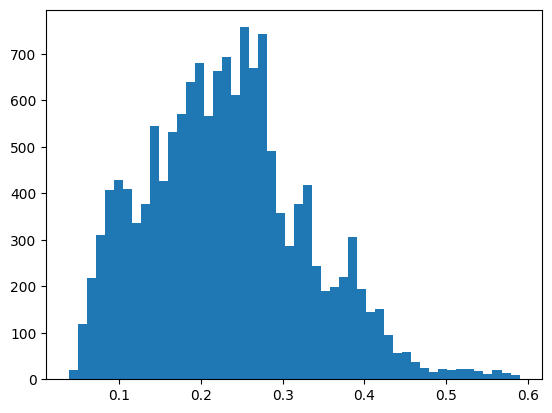

In [854]:
plt.hist(mae_vector, bins=50)

In [855]:
error_thresh = np.max(mae_vector) 
print(f'setting threshold on {error_thresh} ')

setting threshold on 0.5899620652198792 


In [856]:
#Actual ratio of anomalies 
ratio=1-np.count_nonzero(labels_of_test) / len(labels_of_test)
print(ratio)

0.1665442796299016


In [857]:
pred = vae_model.predict(test)[0]
mae_vector_test = get_error_term(pred, test, _rmse=True)
print(f'Avg error {np.mean(mae_vector_test)}\nmedian error {np.median(mae_vector_test)}')
anomalies = (mae_vector_test > (error_thresh))

np.count_nonzero(anomalies) / len(anomalies)

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
Avg error 0.521159827709198
median error 0.5015979409217834


0.1806432662652372

(array([ 26.,  31.,  55.,  62.,  84., 110., 292., 334., 181., 192., 369.,
        505., 325., 358., 324., 279., 180., 309., 444., 337., 332., 380.,
        258., 233., 142.,  79.,  45.,  26.,  27.,   9.,  20.,  13.,   8.,
          8.,   1.,  16.,  17.,  16.,  15.,  12.,  14.,  15.,  15.,  12.,
         80., 114.,  62.,  20.,  14.,   9.]),
 array([0.30243543, 0.31536773, 0.32830003, 0.34123233, 0.35416463,
        0.36709693, 0.38002923, 0.39296153, 0.40589383, 0.41882616,
        0.43175846, 0.44469076, 0.45762306, 0.47055537, 0.48348767,
        0.49641997, 0.50935227, 0.52228457, 0.53521687, 0.54814917,
        0.56108147, 0.57401377, 0.58694607, 0.59987837, 0.61281067,
        0.62574297, 0.63867527, 0.65160757, 0.66453987, 0.67747217,
        0.69040447, 0.70333678, 0.71626908, 0.72920138, 0.74213374,
        0.75506604, 0.76799834, 0.78093064, 0.79386294, 0.80679524,
        0.81972754, 0.83265984, 0.84559214, 0.85852444, 0.87145674,
        0.88438904, 0.89732134, 0.91025364, 0.

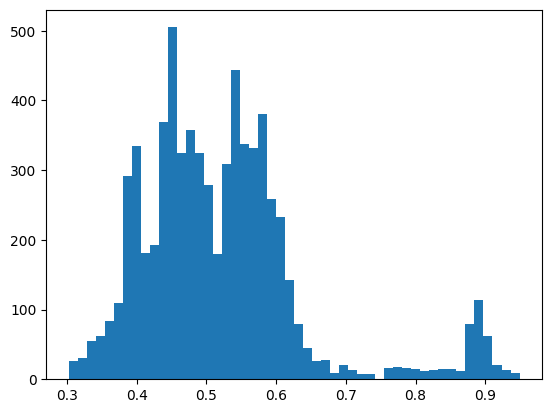

In [858]:
plt.hist(mae_vector_test, bins=50)

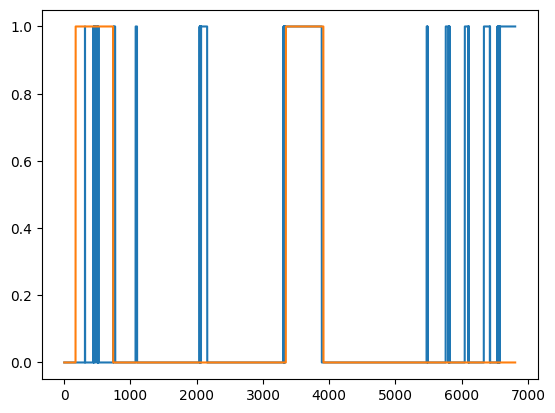

In [859]:
plt.plot(anomalies)
plt.plot(np.logical_not(labels_of_test))

In [860]:
from sklearn.metrics import classification_report
# y_test contains the labels of anomaly =1
print(classification_report(np.logical_not(labels_of_test), anomalies))

              precision    recall  f1-score   support

       False       0.90      0.89      0.90      5675
        True       0.49      0.53      0.51      1134

    accuracy                           0.83      6809
   macro avg       0.70      0.71      0.70      6809
weighted avg       0.83      0.83      0.83      6809



In [861]:
tst_data['anomaly']=anomalies
df = data_w_ts['timestamp']
ts = df.iloc[int(len(data_w_ts) * (1 - test_ratio)) :]
tst_data['timestamp']=ts
tst_data = tst_data[['timestamp','value', 'label','anomaly']]

C:\Users\99anj\AppData\Local\Temp\ipykernel_27840\3776165707.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_data['anomaly']=anomalies
C:\Users\99anj\AppData\Local\Temp\ipykernel_27840\3776165707.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_data['timestamp']=ts


Text(0.5, 1.0, 'Location of the Anomalies on the Time Series, Test Period')

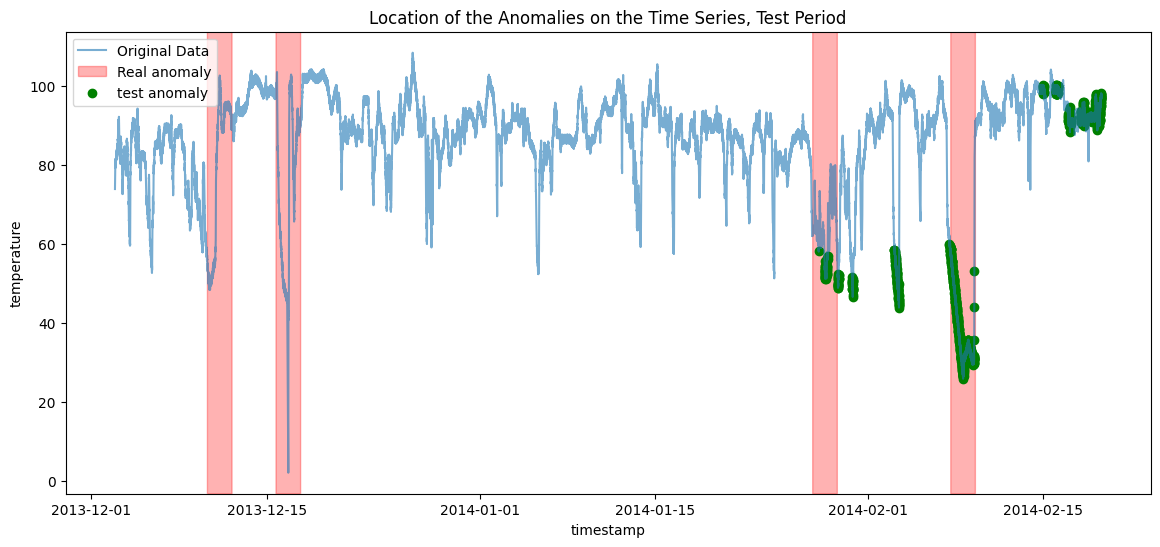

In [862]:
anomalies_ts = data_w_ts.loc[data_w_ts['label']==0, ('timestamp', 'value')]
testing = tst_data.loc[tst_data['anomaly']==True, ('timestamp', 'value')]
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data_w_ts['timestamp'], data_w_ts['value'], label='Original Data', alpha=0.6)
ax.fill_between(data_w_ts['timestamp'], 0, 1, where=np.logical_not(data_w_ts['label']), color='red', alpha=0.3, transform=ax.get_xaxis_transform(),label='Real anomaly')
#ax.scatter(anomalies_ts['timestamp'], anomalies_ts['value'], color='red', label='Real anomaly')
ax.scatter(testing['timestamp'], testing['value'], color='green', label='test anomaly')
plt.legend()
plt.xlabel("timestamp")
plt.ylabel("temperature")
plt.title("Location of the Anomalies on the Time Series, Test Period")

In [863]:
encoded = encoder.predict(test)

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


In [864]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
transform = pca.fit_transform(encoded)

In [865]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=transform[:, 0], y=transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

ValueError: All arrays must be of the same length

<Figure size 1200x1000 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=transform[:, 0], y=transform[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=transform[:, 0], y=transform[:, 1], s=10, hue=labels_of_test)
plt.grid()
plt.show()